In [36]:
!pip install transformers datasets torch torchvision scikit-learn matplotlib


[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [37]:
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms, datasets
from transformers import ResNetConfig, ResNetForImageClassification, AutoImageProcessor
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Directories for dataset
train_dir = './train'
augmented_dir = './augmented'
test_dir = './test'

In [38]:
image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
mean = image_processor.image_mean
std = image_processor.image_std

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
augmented_dataset = datasets.ImageFolder(root=augmented_dir, transform=train_transform)
train_dataset_aug = ConcatDataset([train_dataset, augmented_dataset])

test_dataset = datasets.ImageFolder(root=test_dir, transform=eval_transform)

In [39]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_aug_loader = DataLoader(train_dataset_aug, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


def train_model(model, dataloader, epochs=5, lr=1e-3, device='cuda' if torch.cuda.is_available() else 'cpu'):
    results = []
    
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(dataloader)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

        results.append(evaluate_model(model, test_loader, device=device))
        model.train()

    return model, results


def evaluate_model(model, dataloader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images).logits
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    return accuracy, precision, recall, f1


config = ResNetConfig(num_labels=2)
model_init = ResNetForImageClassification(config)

initial_state = copy.deepcopy(model_init.state_dict())

In [40]:
print("Training model on original train set (no augmentation)")

config = ResNetConfig(num_labels=2)
model_no_aug = ResNetForImageClassification(config)

model_no_aug.load_state_dict(initial_state)
model_no_aug, results_no_aug = train_model(model_no_aug, train_loader, epochs=30)
acc_no_aug, prec_no_aug, rec_no_aug, f1_no_aug = results_no_aug[-1]
print("Test metrics (No Augmentation):")
print(f"Accuracy: {acc_no_aug:.4f}, Precision: {prec_no_aug:.4f}, Recall: {rec_no_aug:.4f}, F1 Score: {f1_no_aug:.4f}")

Training model on original train set (no augmentation)
Epoch 1/30, Loss: 2.3381
Epoch 2/30, Loss: 1.4357
Epoch 3/30, Loss: 0.7980
Epoch 4/30, Loss: 0.6657
Epoch 5/30, Loss: 0.7112
Epoch 6/30, Loss: 0.6552
Epoch 7/30, Loss: 0.6222
Epoch 8/30, Loss: 0.6513
Epoch 9/30, Loss: 0.4697
Epoch 10/30, Loss: 0.3920
Epoch 11/30, Loss: 0.1669
Epoch 12/30, Loss: 0.0939
Epoch 13/30, Loss: 0.2272
Epoch 14/30, Loss: 0.3884
Epoch 15/30, Loss: 0.4629
Epoch 16/30, Loss: 0.4091
Epoch 17/30, Loss: 0.2319
Epoch 18/30, Loss: 0.2664
Epoch 19/30, Loss: 0.1630
Epoch 20/30, Loss: 0.1507
Epoch 21/30, Loss: 0.0671
Epoch 22/30, Loss: 0.0655
Epoch 23/30, Loss: 0.0542
Epoch 24/30, Loss: 0.1087
Epoch 25/30, Loss: 0.0535
Epoch 26/30, Loss: 0.3979
Epoch 27/30, Loss: 0.2999
Epoch 28/30, Loss: 0.3603
Epoch 29/30, Loss: 0.2217
Epoch 30/30, Loss: 0.1632
Test metrics (No Augmentation):
Accuracy: 0.4286, Precision: 0.4125, Recall: 0.4286, F1 Score: 0.4011


In [41]:
print("\nTraining model on augmented train set")

config = ResNetConfig(num_labels=2)
model_aug = ResNetForImageClassification(config)

model_aug.load_state_dict(initial_state)
model_aug, results_aug = train_model(model_aug, train_aug_loader, epochs=50)
acc_aug, prec_aug, rec_aug, f1_aug = results_aug[-1]
print("Test metrics (With Augmentation):")
print(f"Accuracy: {acc_aug:.4f}, Precision: {prec_aug:.4f}, Recall: {rec_aug:.4f}, F1 Score: {f1_aug:.4f}")


Training model on augmented train set
Epoch 1/50, Loss: 1.2413
Epoch 2/50, Loss: 0.7145
Epoch 3/50, Loss: 0.6934
Epoch 4/50, Loss: 0.6005
Epoch 5/50, Loss: 0.5836
Epoch 6/50, Loss: 0.5549
Epoch 7/50, Loss: 0.5984
Epoch 8/50, Loss: 0.4905
Epoch 9/50, Loss: 0.4780
Epoch 10/50, Loss: 0.3439
Epoch 11/50, Loss: 0.3253
Epoch 12/50, Loss: 0.3822
Epoch 13/50, Loss: 0.2950
Epoch 14/50, Loss: 0.3022
Epoch 15/50, Loss: 0.2930
Epoch 16/50, Loss: 0.2306
Epoch 17/50, Loss: 0.1968
Epoch 18/50, Loss: 0.2053
Epoch 19/50, Loss: 0.2214
Epoch 20/50, Loss: 0.1635
Epoch 21/50, Loss: 0.2287
Epoch 22/50, Loss: 0.1273
Epoch 23/50, Loss: 0.1222
Epoch 24/50, Loss: 0.1885
Epoch 25/50, Loss: 0.2394
Epoch 26/50, Loss: 0.1457
Epoch 27/50, Loss: 0.1524
Epoch 28/50, Loss: 0.1737
Epoch 29/50, Loss: 0.1844
Epoch 30/50, Loss: 0.1240
Epoch 31/50, Loss: 0.1118
Epoch 32/50, Loss: 0.1282
Epoch 33/50, Loss: 0.1969
Epoch 34/50, Loss: 0.1949
Epoch 35/50, Loss: 0.2826
Epoch 36/50, Loss: 0.1086
Epoch 37/50, Loss: 0.0671
Epoch 38

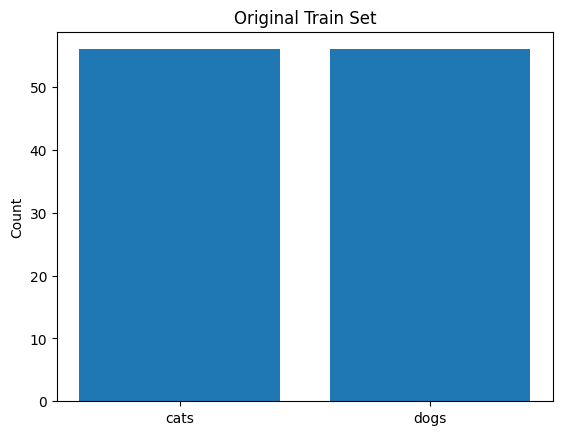

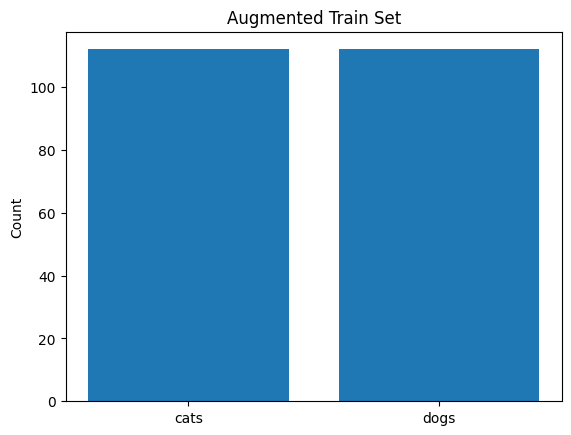

Original train set count: 112
Augmented train set count: 224
Combined train set count: 336


In [42]:
import matplotlib.pyplot as plt


def make_plots(dataset, title):
    class_counts = {}

    for _, label in dataset.samples:
        class_counts[label] = class_counts.get(label, 0) + 1

    # Map indices back to class names using dataset.class_to_idx
    idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
    classes = [idx_to_class[i] for i in sorted(idx_to_class)]
    counts = [class_counts.get(i, 0) for i in sorted(idx_to_class)]

    plt.bar(classes, counts)
    plt.title(title)
    plt.ylabel("Count")
    plt.show()


make_plots(train_dataset, "Original Train Set")
make_plots(augmented_dataset, "Augmented Train Set")

combined_count = len(train_dataset) + len(augmented_dataset)
print(f"Original train set count: {len(train_dataset)}")
print(f"Augmented train set count: {len(augmented_dataset)}")
print(f"Combined train set count: {combined_count}")

In [ ]:
# plot the results_aug and results_no_aug

def plot_results(results_no_aug, results_aug):
    fig, axs = plt.subplots(1, 2, figsize=(12, 10))

    for i, (title, results) in enumerate(zip(["Accuracy", "Precision", "Recall", "F1 Score"],
                                             [results_no_aug, results_aug])):
        for j, metric in enumerate(results[0]):
            axs[i, j].plot([r[i] for r in results], label="No Augmentation")
            axs[i, j].plot([r[i] for r in results_aug], label="With Augmentation")
            axs[i, j].set_title(f"{title} vs Epoch")
            axs[i, j].set_xlabel("Epoch")
            axs[i, j].set_ylabel(title)
            axs[i, j].legend()

    plt.tight_layout()
    plt.show()
    
plot_results(results_no_aug, results_aug)